## SSD Demo

In [51]:

%load_ext autoreload

%autoreload 2   


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import ssd
from architectures.ssd_feature_fused_deconv_eltsum import build_ssd
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Build Net

In [52]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('trained_weights/ssd_VGG16_VOC_feature_fusion_eltsum.pth')
# to use the user input , load an image into test_images directory and assign the path as following
image_path = 'test_images/test_pic_15.jpg'

Loading weights into state dict...
Finished!


### Load Image

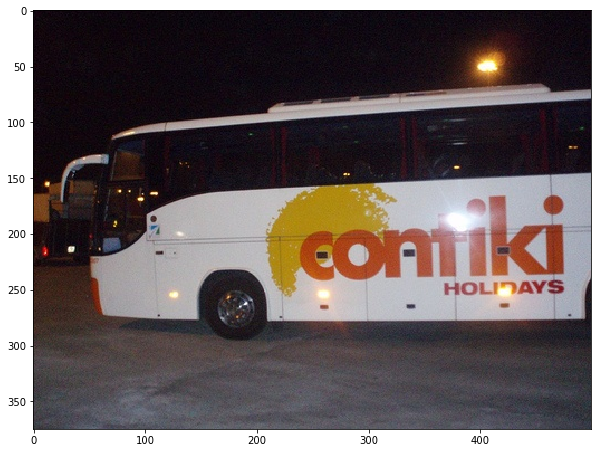

In [81]:
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform

VOC_ROOT = '/datasets/home/12/312/vpotnuru/data/VOC0712/'
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2007', 'test')], None, VOCAnnotationTransform())
img_id = random.randint(0,len(testset))

image,_,_,_ = testset.pull_image(img_id) # comment to use user input 
#image = cv2.imread(image_path)   # to use user input 
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

### Process Image

In [78]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2, 0, 1)

### SSD Forward Prop

In [79]:
img = x.unsqueeze(0)
if torch.cuda.is_available():
    img = img.cuda()
y = net(img)

/opt/conda/conda-bld/pytorch_1573049310284/work/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/opt/conda/conda-bld/pytorch_1573049310284/work/torch/csrc/autograd/python_function.cpp:648: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


###  Detection 

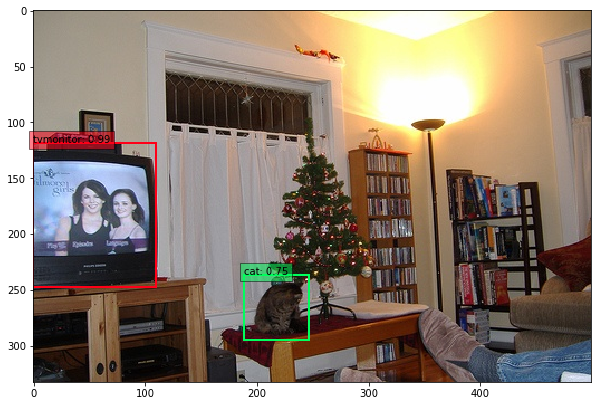

In [80]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1